# Installing dependencies

Please make a copy of this notebook.


# Huggingface login
You will require your personal token.

# Data

## Downloading the train and test dataset

In [1]:
from datasets import load_dataset, DatasetDict, Features, Image, Value
import os

# 1. Point to the root folder that contains both train/ and test/ subfolders
ROOT_DIR  = r"C:\Users\Xiang\Downloads\drive-download-20250422T155327Z-001"
TRAIN_DIR = os.path.join(ROOT_DIR, "train")
TEST_DIR  = os.path.join(ROOT_DIR, "test")

# 2. Load both CSVs at once into a DatasetDict
data_files = {
    "train": os.path.join(TRAIN_DIR, "metadata.csv"),
    "test":  os.path.join(TEST_DIR,  "metadata.csv"),
}
ds = load_dataset(
    "csv",
    data_files=data_files,
    delimiter=","
)  # → DatasetDict({'train': Dataset(...), 'test': Dataset(...)})

# 3. Define two small mapping functions to add the full image path
def add_train_image(example):
    return {"image": os.path.join(TRAIN_DIR, example["file_name"])}

def add_test_image(example):
    return {"image": os.path.join(TEST_DIR,  example["file_name"])}

# 4. Map them to each split
ds["train"] = ds["train"].map(add_train_image)
ds["test"]  = ds["test"].map(add_test_image)

# 5. Tell 🤗 Datasets what each column really is
features = Features({
    "file_name": Value("string"),   # keep it around if you like
    "image":     Image(),           # will load via PIL on access
    "Latitude":  Value("float32"),
    "Longitude": Value("float32"),
})
ds = ds.cast(features)

# 6. (Optional) drop the original filename column now that "image" exists
ds["train"] = ds["train"].remove_columns("file_name")
ds["test"]  = ds["test"].remove_columns("file_name")

print(ds)


DatasetDict({
    train: Dataset({
        features: ['image', 'Latitude', 'Longitude'],
        num_rows: 673
    })
    test: Dataset({
        features: ['image', 'Latitude', 'Longitude'],
        num_rows: 260
    })
})


In [2]:
dataset_train = ds["train"]
dataset_test = ds["test"]

## Defining the Custom Dataset Class

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification
from huggingface_hub import PyTorchModelHubMixin
from PIL import Image
import os
import numpy as np

class CustomResNetModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, model_name="microsoft/resnet-152", num_classes=2):
        super().__init__()

        # Load pre-trained ResNet model from Hugging Face
        self.resnet = AutoModelForImageClassification.from_pretrained(model_name)

        # Access the Linear layer within the Sequential classifier
        in_features = self.resnet.classifier[1].in_features  # Accessing the Linear layer within the Sequential

        # Modify the classifier layer to have the desired number of output classes
        self.resnet.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

    def save_model(self, save_path):
        """Save model locally using the Hugging Face format."""
        self.save_pretrained(save_path)

    def push_model(self, repo_name):
        """Push the model to the Hugging Face Hub."""
        self.push_to_hub(repo_name)

class GPSImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, lat_mean=None, lat_std=None, lon_mean=None, lon_std=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

        # Compute mean and std from the dataframe if not provided
        self.latitude_mean = lat_mean if lat_mean is not None else np.mean(np.array(self.hf_dataset['Latitude']))
        self.latitude_std = lat_std if lat_std is not None else np.std(np.array(self.hf_dataset['Latitude']))
        self.longitude_mean = lon_mean if lon_mean is not None else np.mean(np.array(self.hf_dataset['Longitude']))
        self.longitude_std = lon_std if lon_std is not None else np.std(np.array(self.hf_dataset['Longitude']))

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Extract data
        example = self.hf_dataset[idx]

        # Load and process the image
        image = example['image']
        latitude = example['Latitude']
        longitude = example['Longitude']
        # image = image.rotate(-90, expand=True)
        if self.transform:
            image = self.transform(image)

        # Normalize GPS coordinates
        latitude = (latitude - self.latitude_mean) / self.latitude_std
        longitude = (longitude - self.longitude_mean) / self.longitude_std
        gps_coords = torch.tensor([latitude, longitude], dtype=torch.float32)

        return image, gps_coords

## Creating dataloaders and visualizing the data

In [5]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(degrees=15),  # Random rotation between -15 and 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Optionally, you can create a separate transform for inference without augmentations
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



# Create the training dataset and dataloader
train_dataset = GPSImageDataset(hf_dataset=dataset_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Retrieve normalization parameters from the training dataset
lat_mean = train_dataset.latitude_mean
lat_std = train_dataset.latitude_std
lon_mean = train_dataset.longitude_mean
lon_std = train_dataset.longitude_std

# Create the validation dataset and dataloader using training mean and std
val_dataset = GPSImageDataset(
    hf_dataset=dataset_test,
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [6]:
# Verify loading
for images, gps_coords in train_dataloader:
    print(images.size(), gps_coords.size())
    break

torch.Size([64, 3, 224, 224]) torch.Size([64, 2])


In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    tensor = tensor.numpy().transpose((1, 2, 0))  # Convert from C x H x W to H x W x C
    tensor = std * tensor + mean  # Denormalize
    tensor = np.clip(tensor, 0, 1)  # Clip to keep pixel values between 0 and 1
    return tensor

data_iter = iter(train_dataloader)
images, gps_coords = next(data_iter)  # Get a batch of images and labels
# Denormalize the first image in the batch for display
itr = 0
# for im in images:
#   image = denormalize(im, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#   # Plot the image
#   plt.imshow(image)
#   plt.title(f'Latitude: {gps_coords[itr][0].item():.4f}, Longitude: {gps_coords[itr][1].item():.4f}')
#   plt.axis('off')
#   plt.show()
#   itr += 1

# Resnet

In [8]:
import torch.nn as nn
import torch.optim as optim
from geopy.distance import geodesic
from torch.optim.lr_scheduler import StepLR
from transformers import AutoImageProcessor, AutoModelForImageClassification

lowest_loss = float('inf')

# Load the pre-trained ResNet18 model
resnet = models.resnet18(pretrained=False)

# Modify the last fully connected layer to output 2 values (latitude and longitude)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)  # Latitude and Longitude

# Not freeze pre-trained weights (excluding the final layer)
for param in resnet.parameters():
    param.requires_grad = True

for param in resnet.fc.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.MSELoss()
# If not fine tuning
# optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001)
# If fine tuning
optimizer = torch.optim.Adam(
    resnet.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

# Add a learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
resnet = resnet.to(device)

# Training loop with validation
num_epochs = 10
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for images, gps_coords in train_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, gps_coords)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet.eval()
    val_loss = 0.0
    baseline_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, gps_coords in val_dataloader:
            images = images.to(device)
            gps_coords = gps_coords.to(device)

            batch_size = gps_coords.size(0)
            total_samples += batch_size

            # Model predictions
            outputs = resnet(images)

            # Denormalize predictions and actual GPS coordinates
            preds_denorm = outputs.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
            actuals_denorm = gps_coords.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

            # Compute geodesic distances between predictions and actuals
            for pred, actual in zip(preds_denorm, actuals_denorm):
                distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
                val_loss += distance ** 2  # Squared distance

            # Baseline predictions
            baseline_preds = np.array([lat_mean, lon_mean])

            # Compute geodesic distances between baseline preds and actuals
            for actual in actuals_denorm:
                distance = geodesic((actual[0], actual[1]), (baseline_preds[0], baseline_preds[1])).meters
                baseline_loss += distance ** 2  # Squared distance

    # Compute average losses
    val_loss /= total_samples
    baseline_loss /= total_samples

    # Compute RMSE
    val_rmse = np.sqrt(val_loss)
    baseline_rmse = np.sqrt(baseline_loss)

    if (val_loss < lowest_loss):
        lowest_loss = val_loss
        # Save the model if validation loss improves
        print("Saving the best model...")
        torch.save(resnet, 'baseline_model.pth')

    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss (meters^2): {val_loss:.2f}, Baseline Loss (meters^2): {baseline_loss:.2f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation RMSE (meters): {val_rmse:.2f}, Baseline RMSE (meters): {baseline_rmse:.2f}")

print('Training complete')


c:\Users\Xiang\anaconda3\envs\cis5810-p7\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Xiang\anaconda3\envs\cis5810-p7\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using device: cuda
Epoch [1/10], Training Loss: 1.0759
Saving the best model...
Epoch [1/10], Validation Loss (meters^2): 10867.77, Baseline Loss (meters^2): 9346.45
Epoch [1/10], Validation RMSE (meters): 104.25, Baseline RMSE (meters): 96.68
Epoch [2/10], Training Loss: 1.0100
Saving the best model...
Epoch [2/10], Validation Loss (meters^2): 8872.62, Baseline Loss (meters^2): 9346.45
Epoch [2/10], Validation RMSE (meters): 94.19, Baseline RMSE (meters): 96.68
Epoch [3/10], Training Loss: 0.9867
Epoch [3/10], Validation Loss (meters^2): 9065.43, Baseline Loss (meters^2): 9346.45
Epoch [3/10], Validation RMSE (meters): 95.21, Baseline RMSE (meters): 96.68
Epoch [4/10], Training Loss: 0.9605
Epoch [4/10], Validation Loss (meters^2): 9151.12, Baseline Loss (meters^2): 9346.45
Epoch [4/10], Validation RMSE (meters): 95.66, Baseline RMSE (meters): 96.68
Epoch [5/10], Training Loss: 0.9469
Saving the best model...
Epoch [5/10], Validation Loss (meters^2): 8471.46, Baseline Loss (meters^2):

# Testing the model

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize lists to store predictions and actual values
all_preds = []
all_actuals = []
distances = []
resnet.eval()
with torch.no_grad():
    for images, gps_coords in val_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        outputs = resnet(images)

        # Denormalize predictions and actual values
        preds = outputs.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        actuals = gps_coords.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds)
        all_actuals.append(actuals)

        for pred, actual in zip(preds, actuals):
          distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
          distances.append(distance)

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_actuals = torch.cat(all_actuals).numpy()

# Compute error metrics
mae = mean_absolute_error(all_actuals, all_preds)
rmse = mean_squared_error(all_actuals, all_preds, squared=False)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

avg_distance = sum(distances) / len(distances)
print(f"Avg Distance: {avg_distance}")

Mean Absolute Error: 0.0005207134416810943
Root Mean Squared Error: 0.0006311295106348962
Avg Distance: 81.06706484369388


In [10]:
import numpy as np

# Retrieve normalization parameters from the training dataset
lat_mean = train_dataset.latitude_mean
lat_std = train_dataset.latitude_std
lon_mean = train_dataset.longitude_mean
lon_std = train_dataset.longitude_std

# Denormalize predictions and actual values
all_preds_denorm = all_preds * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
all_actuals_denorm = all_actuals * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

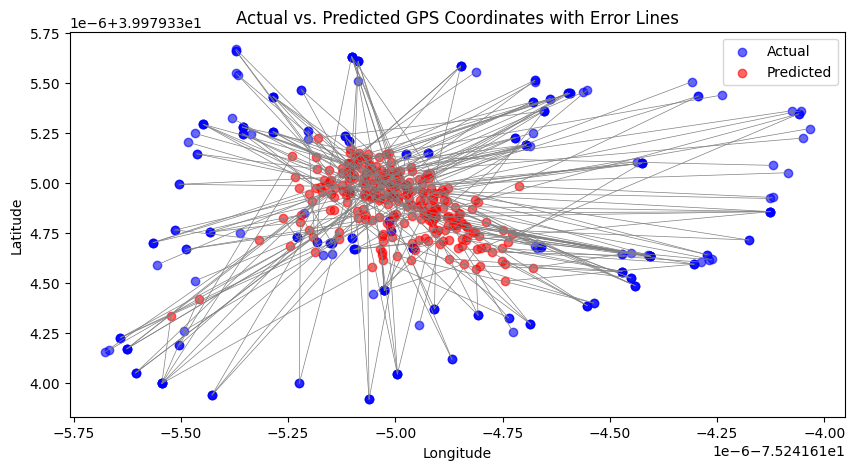

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot actual points
plt.scatter(all_actuals_denorm[:, 1], all_actuals_denorm[:, 0], label='Actual', color='blue', alpha=0.6)

# Plot predicted points
plt.scatter(all_preds_denorm[:, 1], all_preds_denorm[:, 0], label='Predicted', color='red', alpha=0.6)

# Draw lines connecting actual and predicted points
for i in range(len(all_actuals_denorm)):
    plt.plot(
        [all_actuals_denorm[i, 1], all_preds_denorm[i, 1]],
        [all_actuals_denorm[i, 0], all_preds_denorm[i, 0]],
        color='gray', linewidth=0.5
    )

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs. Predicted GPS Coordinates with Error Lines')
plt.show()

# Loads the model and use it for testing on given dataset

You load this model by running

In [ ]:
import torch
resnet = torch.load("baseline_model.pth")


C:\Users\Xiang\AppData\Local\Temp\ipykernel_158936\1161122022.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet = torch.load("best_model.pth")


In [12]:
#load the parquet file
dataset_test = load_dataset("gydou/released_img", split="train")

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

In [14]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# Imports (add if not already present)
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from geopy.distance import geodesic
import torch

# 1. Wrap the HF dataset in your GPSImageDataset
test_dataset = GPSImageDataset(
    hf_dataset=dataset_test,
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Run evaluation
resnet.eval()
all_preds = []
all_actuals = []
distances = []

with torch.no_grad():
    for images, coords in test_loader:
        images, coords = images.to(device), coords.to(device)
        outputs = resnet(images)

        # Denormalize back to degrees
        preds = outputs.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        actuals = coords.cpu()  * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds)
        all_actuals.append(actuals)

        for p, a in zip(preds, actuals):
            distances.append(geodesic((a[0].item(), a[1].item()),
                                     (p[0].item(), p[1].item())).meters)

# 3. Compute metrics
all_preds = torch.cat(all_preds).numpy()
all_actuals = torch.cat(all_actuals).numpy()

mae = mean_absolute_error(all_actuals, all_preds)
rmse = mean_squared_error(all_actuals, all_preds, squared=False)
avg_dist = sum(distances) / len(distances)

print(f"Test MAE (°): {mae:.4f}")
print(f"Test RMSE (°): {rmse:.4f}")
print(f"Avg geodesic distance (m): {avg_dist:.2f}")

Test MAE (°): 0.0005
Test RMSE (°): 0.0006
Avg geodesic distance (m): 75.61
